<a href="https://colab.research.google.com/github/nfleischmann/Gradient-Based-Methods-for-the-Training-of-Neural-Networks/blob/main/experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2 Efficiency of Gradient-Based Methods

In the following experiment, we want to compare gradient descent with the presented stochastic gradient methods for training sets of different sizes. Thereby, we let the methods process the same number of observations and investigate how fast they can decrease the costs. 

In [ ]:
# Load libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

## Training Sets

Since we want to observe the impact of the training set size on the different methods, we have to ensure that the respective training sets are similar. To this end, we generate training sets of the sizes 100, 1000, and 10,000 by randomly sampling observations from the well-known California housing dataset.

In [ ]:
# Load the California housing dataset
X, y = fetch_california_housing(return_X_y = True)

# Preprocess the inputs and outputs with a standard scaler to facilitate the training
scaler_X = StandardScaler().fit(X)
X = scaler_X.transform(X)
y = y.reshape(-1, 1)
scaler_y = StandardScaler().fit(y)
y = scaler_y.transform(y)

n = X.shape[0]

In [ ]:
# Generate the samples for the different training sets
rng = np.random.default_rng(42)
rng.choice(n, 10, replace=False)
small_sample = rng.choice(n, 100, replace=False)
medium_sample = rng.choice(n, 1000, replace=False)
large_sample = rng.choice(n, 10000, replace=False)
samples = [small_sample,medium_sample,large_sample]

## Neural Networks

We use a neural network with eight input neurons, five hidden layers with twelve neurons per layer, and a single output neuron throughout the experiment. As the activation function for the hidden neurons, we employ the ReLU and use the identity as the activation function for the output neuron.

In [ ]:
def build_model(input_shape=[8], n_hidden=5, width=12, seed=42):
  """ Builds a neural network model

    Args:
        input_shape (list): Shape of the input layer
          (default is [8])
        n_hidden (int): Number of hidden layers
          (default is 5)
        width (int): Width of the hidden layers
          (default is 12)
        seed (int): Seed that makes the inialization of the model reproducible
          (default is 42)

    Returns:
        tf.keras.model: Initialized neural network model
  """
  # Initialize neural network model
  tf.random.set_seed(seed)
  model = keras.models.Sequential() 

  # Add input layer
  model.add(keras.layers.InputLayer(input_shape=input_shape)) 

  # Add hidden layers
  for layer in range(n_hidden): 
    model.add(keras.layers.Dense(width, activation="ReLU"))

  # Add output layer
  model.add(keras.layers.Dense(1,activation="linear"))

  return model

## Gradient-Based Methods

We compare gradient descent, stochastic gradient descent, and mini-batch gradient descent with a mini-batch size of 50. The standard implementation of Keras generates the samples for the stochastic gradient methods by shuffeling the training set and cycling through it (as we explained in Section 4.5.3). For this reason, we provide an alternative implementation that draws the mini-batch uniformly (with replacement) from the training set.

In [ ]:
def mini_batch_gradient_descent(model, X, y, observations, step_size, mini_batch_size, seed=42, compute_metrics=False):
  """ Implementation of mini-batch gradient descent with randomly drawn mini-batches

    Args:
        model: Keras model 
        X (np.ndarray): Inputs of the training set
        y (np.ndarray): Outputs of the training set
        observations (int): Number of observations the method processes
        step_size (int): Step size
        mini_batch_size (int): Size of the mini-batch
        seed (int): Seed used to make the drawn mini-batches reproduceable
          (default is 42)
        compute_metrics (bool): Determines if the method returns a data frame with
                                the costs of all iterates or just the cost of the
                                last iterate
          (default is False)

    Returns:
        float: cost of the last iterate
          or
        pd.DataFrame: costs of all iterates
  """

  # Initialize the loss function and the optimizer (which determines the update rule)
  square_loss = tf.keras.losses.MeanSquaredError()
  optimizer = keras.optimizers.SGD(learning_rate=step_size)

  rng = np.random.default_rng(seed)
  n = X.shape[0]
  steps = observations // mini_batch_size

  if compute_metrics:
    metrics = pd.DataFrame(columns=['observations','cost'])
    y_pred = model.predict(X)
    metrics.loc[0,'cost'] = square_loss(y, y_pred).numpy()
    metrics.loc[0,'observations'] = 0
    idx = 1
  
  for step in range(steps):
    # Sample the minibatch uniformly from the training set
    mini_batch = rng.choice(n,mini_batch_size)
    X_mini_batch = X[mini_batch]
    y_mini_batch = y[mini_batch]
            
    # Compute the average of the loss gradients for the observations in the mini-batch 
    with tf.GradientTape() as tape:
      pred = model(X_mini_batch, training=True)
      loss = square_loss(y_mini_batch, pred)
    grad = tape.gradient(loss, model.trainable_weights)

    # Perform a step of mini-batch gradient descent
    optimizer.apply_gradients(zip(grad, model.trainable_weights))

    if compute_metrics:
      y_pred = model.predict(X)
      metrics.loc[idx,'cost'] = square_loss(y, y_pred).numpy()
      metrics.loc[idx,'observations'] = (step + 1) * mini_batch_size
      idx = idx + 1

  if compute_metrics:
    return metrics
  else:
    y_pred = model.predict(X)
    return square_loss(y, y_pred).numpy()

In [ ]:
def gradient_descent(model, X, y, observations, step_size, compute_metrics=False):
  """ Implementation of gradient descent

    Args:
        model: Keras model 
        X (np.ndarray): Inputs of the training set
        y (np.ndarray): Outputs of the training set
        observations (int): Number of observations the method processes
        step_size(int): Step size
        compute_metrics(bool): Determines if the method returns a data frame with
                               the costs of all iterates or just the cost of the
                               last iterate
          (default is False)

    Returns:
        float: cost of the last iterate
          or
        pd.DataFrame: costs of all iterates
  """
  
  # Define the loss function and the optimizer(which determines the update rule)
  square_loss = tf.keras.losses.MeanSquaredError()
  optimizer = keras.optimizers.SGD(learning_rate=step_size)

  n = X.shape[0]
  steps = observations // n

  if compute_metrics:
    metrics = pd.DataFrame(columns=['observations','cost'])
    y_pred = model.predict(X)
    metrics.loc[0,'cost'] = square_loss(y, y_pred).numpy()
    metrics.loc[0,'observations'] = 0
    idx = 1

  for step in range(steps):  

    # Compute the gradient
    with tf.GradientTape() as tape:
      pred = model(X, training=True)
      loss = square_loss(y, pred)
    grad = tape.gradient(loss, model.trainable_weights)

    # Perform a step of gradient descent
    optimizer.apply_gradients(zip(grad, model.trainable_weights))

    if compute_metrics:
      y_pred = model.predict(X)
      metrics.loc[idx,'cost'] = square_loss(y, y_pred).numpy()
      metrics.loc[idx,'observations'] = (step + 1) * n
      idx = idx + 1
  
  if compute_metrics:
    return metrics
  else:
    y_pred = model.predict(X)
    return square_loss(y, y_pred).numpy()

## Tune Step Sizes

In order to make the comparison between the methods fair, we decided to tune the step size. For each training set and each method we run every method with the step sizes $\alpha \in \{$1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005$\}$ and select the one that yields the lowest cost. 

In [ ]:
step_sizes = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005]
methods = ["sgd","mb_gd","gd"]

tune_df = pd.DataFrame(columns=['training_set_size','method','step_size','cost'])
idx = 0

for sample in samples:
  X_train = X[sample]
  y_train = y[sample]
  training_set_size = X_train.shape[0]
  observations = training_set_size * 20
  for method in methods:
    for step_size in step_sizes:
      model = build_model()
      if method == "sgd":
        cost = mini_batch_gradient_descent(model, X_train, y_train, observations,
                                           step_size, mini_batch_size=1)
      elif method == "mb_gd":
        cost = mini_batch_gradient_descent(model, X_train, y_train, observations,
                                           step_size, mini_batch_size=50)
      else:
        cost = gradient_descent(model, X_train, y_train, observations, step_size)
        
      tune_df.loc[idx,'training_set_size'] = training_set_size
      tune_df.loc[idx,'method'] = method
      tune_df.loc[idx,'step_size'] = step_size
      tune_df.loc[idx,'cost'] = cost
      idx = idx + 1

## Results of the Tuning

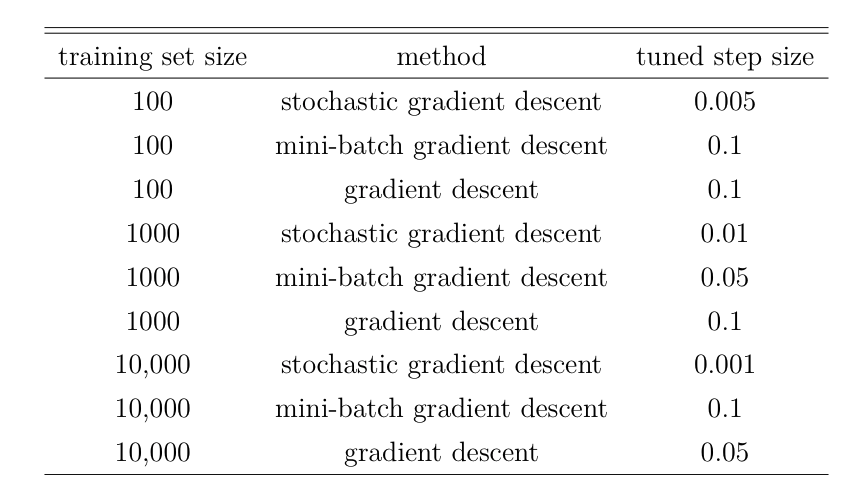

## Final Run

We run the methods once again with the tuned step sizes and compute the cost after each iteration.

### Small Training Set (n = 100)

In [ ]:
# Small training set
X_train = X[small_sample]
y_train = y[small_sample]
observations = X_train.shape[0] * 20 

# Compute Metrics for Stochastic Gradient Descent
model = build_model()
sgd_100 = mini_batch_gradient_descent(model, X_train, y_train, observations,
                                      step_size=0.005, mini_batch_size=1,
                                      compute_metrics=True)

# Compute Metrics for Mini-Batch Gradient Descent
model = build_model()
mb_gd_100 = mini_batch_gradient_descent(model, X_train, y_train, observations, 
                                        step_size=0.1, mini_batch_size=50,
                                        compute_metrics=True)

# Compute Metrics for Gradient Descent
model = build_model()
gd_100 = gradient_descent(model, X_train, y_train, observations, step_size=0.1,
                          compute_metrics=True)

### Medium Training Set (n = 1000)

In [ ]:
# Medium training set
X_train = X[medium_sample]
y_train = y[medium_sample]
observations = X_train.shape[0] * 20 

# Compute Metrics for Stochastic Gradient Descent
model = build_model()
sgd_1000 = mini_batch_gradient_descent(model, X_train, y_train, observations,
                                       step_size=0.01, mini_batch_size=1,
                                       compute_metrics=True)

# Compute Metrics for Mini-Batch Gradient Descent
model = build_model()
mb_gd_1000 = mini_batch_gradient_descent(model, X_train, y_train, observations,
                                         step_size=0.05, mini_batch_size=50,
                                         compute_metrics=True)

# Compute Metrics for Gradient Descent
model = build_model()
gd_1000 = gradient_descent(model, X_train, y_train, observations, step_size=0.1, 
                           compute_metrics=True)

### Large Training Set (n = 10000)

In [ ]:
# Large training set
X_train = X[large_sample]
y_train = y[large_sample]
observations = X_train.shape[0] * 20 

# Compute Metrics for Stochastic Gradient Descent
model = build_model()
sgd_10000 = mini_batch_gradient_descent(model, X_train, y_train, observations, 
                                        step_size=0.001, mini_batch_size=1,
                                        compute_metrics = True)

# Compute Metrics for Mini-Batch Gradient Descent
model = build_model()
mb_gd_10000 = mini_batch_gradient_descent(model, X_train, y_train, observations,
                                          step_size=0.1, mini_batch_size=50,
                                          compute_metrics=True)

# Compute Metrics for Gradient Descent
model = build_model()
gd_10000 = gradient_descent(model, X_train, y_train, observations, step_size=0.05,
                            compute_metrics=True)